### Generate NEO4J database from relational tweet model

- Exploring the use of CSV files instead of direct create commands
- Hopefully this will be much faster
- See this link for explanation of the method: https://neo4j.com/developer/guide-importing-data-and-etl/

In [1]:
import pandas as pd
from neo4j import GraphDatabase, basic_auth
import getpass
import pickle
import time
from ipywidgets import IntProgress
from IPython.display import display

In [2]:
fpath  = '/home/akash/.local/share/neo4j-relate/dbmss/dbms-b10595d5-b636-463b-8582-42880ffe223d/import'

In [3]:
url="bolt://localhost:7687"
user="neo4j"
pw=getpass.getpass()

········


In [4]:
if "session" in locals():
    session.last_bookmark()
    session.close()

In [5]:
driver = GraphDatabase.driver(url )
session = driver.session()

In [6]:
#run this once
session.run("create constraint  on (u:user) assert u.uid is unique")
session.run("create constraint  on (t:tweet) assert t.id is unique")
session.run("create constraint  on (h:hashtag) assert h.name is unique")

ClientError: {code: Neo.ClientError.Schema.EquivalentSchemaRuleAlreadyExists} {message: An equivalent constraint already exists, 'Constraint( id=2, name='constraint_656edfaa', type='UNIQUENESS', schema=(:user {uid}), ownedIndex=1 )'.}

In [7]:
querytw="""
LOAD CSV WITH HEADERS FROM 'file:///tweets.csv' AS row
MERGE (t:tweet {id: toInteger(row.tID)})
  ON CREATE SET t.text = row.text,
    t.happy = toFloat(row.happy),
    t.angry = toFloat(row.angry),
    t.surprise = toFloat(row.surprise),
    t.sad = toFloat (row.sad),
    t.fear = toFloat (row.fear),
    t.date = Datetime(row.strdate),
    t.reply_count = toInteger(row.reply_count),
    t.retweet_count = toInteger(row.retweet_count),
    t.quote_count = toInteger(row.quote_count),
    t.favorite_count = toInteger(row.favorite_count),
    t.retweet = toBoolean(row.retweet),
    t.quote = toBoolean(row.quote),
    t.reply = toBoolean(row.reply),
    t.topic = row.topic
"""

#users
queryu="""
LOAD CSV WITH HEADERS FROM 'file:///users.csv' AS row
MERGE (u:user {uid: toInteger(row.uID)})
  ON CREATE SET u.screen_name = row.screen_name,
    u.created = Datetime(row.strcreated),
    u.description = row.description,
    u.location = row.location,
    u.friends_count = toInteger(row.friends_count)
"""

#posts
queryp="""
LOAD CSV WITH HEADERS FROM 'file:///posts.csv' AS row
MATCH (u:user {uid: toInteger(row.uID)}), (t:tweet {id: toInteger(row.tID)})
MERGE (u)-[:POSTED]->(t)
"""

#retweets
queryrt="""
LOAD CSV WITH HEADERS FROM 'file:///retweets.csv' AS row
MATCH (t:tweet {id: toInteger(row.tID)}), (r:tweet {id: toInteger(row.tID_re)})
MERGE (t)-[:RETWEETED]->(r)
"""

#mentions
queryme="""
LOAD CSV WITH HEADERS FROM 'file:///mentions.csv' AS row
MATCH (t:tweet {id: toInteger(row.tID)}), (u:user {uid: toInteger(row.uID)})
MERGE (t)-[:MENTIONED]->(u)
"""

#quotes
queryqo="""
LOAD CSV WITH HEADERS FROM 'file:///quotes.csv' AS row
MATCH (t:tweet {id: toInteger(row.tID)}), (q:tweet {id: toInteger(row.tID_qo)})
MERGE (t)-[:QUOTED]->(q)
"""


#replies
queryre="""
LOAD CSV WITH HEADERS FROM 'file:///replies.csv' AS row
MATCH (t:tweet {id: toInteger(row.tID)}), (r:tweet {id: toInteger(row.tID_rp)})
MERGE (t)-[:REPLIED]->(r)
"""


queryht="""
LOAD CSV WITH HEADERS FROM 'file:///hashtags.csv' AS row
MERGE (h:hashtag {name: row.name})
"""

#tags
queryt="""
LOAD CSV WITH HEADERS FROM 'file:///tags.csv' AS row
MATCH (t:tweet {id: toInteger(row.tID)}), (h:hashtag {name: row.hashtag})
MERGE (t)-[:TAGGED]->(h)
"""


In [8]:
def df2neo4j_split(adf, myquery, csvfile, index_label="mID", wrnodes_per_op = 1000):
    nel=len(adf)
    wb = IntProgress(min=0, max=nel) 
    display(wb)
    
    t1=time.time()

    for p in range(0,nel, wrnodes_per_op):
        wb.value=p
        start=p
        end=min(p+wrnodes_per_op, nel)
        
        adf.iloc[start:end,:].to_csv(csvfile, index_label=index_label)
        
        print("\rCreating node/edge (%05d/%05d) ...      " % (p,nel), end="")
        
        session.run(myquery)
    
    t2=time.time()

    print("\nTime to generate %d nodes/edges: %d seconds" % (nel, t2-t1))

In [67]:
from glob import glob

l = glob('political_tweets/pickles/*.pkl')

In [68]:
for file in l[6:]:
    print("Working on %s"%file.split('/')[2])
    alldf=pickle.load(open(file, "rb"))
    #for key in alldf.keys():
    #    print(key, len(alldf[key]))
    tweets=alldf['tweets']
    users=alldf['users']
    posts=alldf['posts']
    mentions=alldf['mentions']
    retweets=alldf['retweets']
    quotes=alldf['quotes']
    tags=alldf['tags']
    contains=alldf['contains']
    replies=alldf['replies']
    
    #escape backslashes and quotes
    tweets["text"]=tweets["text"].str.replace('\n', '\\n"')
    tweets["text"]=tweets["text"].str.replace('\"', '\'')
    tweets["text"]=tweets["text"].str.rstrip('\\')
    tweets["text"]=tweets["text"].str.replace('\\r', '\\n')
    
    #Convert pandas datetime to string readable by Cypher datetime function
    tweets["strdate"]=tweets["date"].map(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S+00:00"))
    
    tweets["strdate"].head()
    
    #Dump Tweets 
    df2neo4j_split(tweets, querytw, '%s/tweets.csv' % fpath, index_label='tID')
    print(session.run("match (t:tweet) return count(t)").data())
    
    for key in ["screen_name", "description"]:
        users[key]=users[key].str.replace('\n', '\\n"')
        users[key]=users[key].str.replace('\r', '\\n"')
        users[key]=users[key].str.replace('\"', '\'')
        users[key]=users[key].str.rstrip('\\')
        users["strcreated"]=users["created"].map(lambda x: x.strftime("%Y-%m-%dT%H:%M:%S+00:00"))
    
    #Users
    df2neo4j_split(users, queryu, '%s/users.csv' % fpath, index_label='uID')
    print(session.run("match (u:user) return count(u)").data())
    
    df2neo4j_split(posts, queryp, '%s/posts.csv' % fpath)
    print(session.run("match (u:user)-[p:POSTED]->(t:tweet) return count(p)").data())
    
    df2neo4j_split(retweets, queryrt, "%s/retweets.csv" % fpath)
    print(session.run("match (t:tweet)-[p:RETWEETED]->(r:tweet) return count(p)").data())
    
    
    df2neo4j_split(mentions, queryme, "%s/mentions.csv" % fpath)
    print(session.run("match (t:tweet)-[m:MENTIONED]->(u:user) return count(m)").data())
    
    df2neo4j_split(quotes, queryqo, "%s/quotes.csv" % fpath)
    print(session.run("match (t:tweet)-[q:QUOTED]->(qo:tweet) return count(q)").data())
        
    df2neo4j_split(replies, queryre, "%s/replies.csv" % fpath)
    print(session.run("match (t:tweet)-[r:REPLIED]->(re:tweet) return count(r)").data())
    
    #Creating hashtag nodes
    htags=pd.DataFrame(tags["hashtag"].unique(), columns=["ht"])
    htags.set_index("ht").to_csv("%s/hashtags.csv" % fpath, index_label="name")
    session.run(queryht)
    print(session.run("match (ht:hashtag) return ht.name limit 10").data())
    
    #Creating hashtag edges
    df2neo4j_split(tags, queryt, "%s/tags.csv" % fpath)
    print(session.run("match (t:tweet)-[a:TAGGED]->(h:hashtag) return count(a)").data())    

Working on public_tackling_covid.pkl


IntProgress(value=0, max=156368)

Creating node/edge (156000/156368) ...      
Time to generate 156368 nodes/edges: 10 seconds
[{'count(t)': 750918}]


IntProgress(value=0, max=122847)

Creating node/edge (122000/122847) ...      
Time to generate 122847 nodes/edges: 4 seconds
[{'count(u)': 437344}]


IntProgress(value=0, max=177591)

Creating node/edge (177000/177591) ...      
Time to generate 177591 nodes/edges: 6 seconds
[{'count(p)': 750918}]


IntProgress(value=0, max=122556)

Creating node/edge (122000/122556) ...      
Time to generate 122556 nodes/edges: 3 seconds
[{'count(p)': 243881}]


IntProgress(value=0, max=204631)

Creating node/edge (204000/204631) ...      
Time to generate 204631 nodes/edges: 5 seconds
[{'count(m)': 762893}]


IntProgress(value=0, max=27591)

Creating node/edge (27000/27591) ...      
Time to generate 27591 nodes/edges: 0 seconds
[{'count(q)': 131311}]


IntProgress(value=0, max=15468)

Creating node/edge (15000/15468) ...      
Time to generate 15468 nodes/edges: 0 seconds
[{'count(r)': 29082}]
[{'ht.name': 'nitricil'}, {'ht.name': 'endsarsnow'}, {'ht.name': 'walkaway'}, {'ht.name': 'trumpvirus'}, {'ht.name': 'taxpayers'}, {'ht.name': 'bidentownhall'}, {'ht.name': 'boycotttrumptownhall'}, {'ht.name': 'nbcblackout'}, {'ht.name': 'trump'}, {'ht.name': 'weloveyoutrump'}]


IntProgress(value=0, max=29965)

Creating node/edge (29000/29965) ...      
Time to generate 29965 nodes/edges: 0 seconds
[{'count(a)': 146648}]
Working on health_workers.pkl


IntProgress(value=0, max=154177)

Creating node/edge (154000/154177) ...      
Time to generate 154177 nodes/edges: 9 seconds
[{'count(t)': 898727}]


IntProgress(value=0, max=111678)

Creating node/edge (111000/111678) ...      
Time to generate 111678 nodes/edges: 3 seconds
[{'count(u)': 487786}]


IntProgress(value=0, max=178488)

Creating node/edge (178000/178488) ...      
Time to generate 178488 nodes/edges: 5 seconds
[{'count(p)': 898727}]


IntProgress(value=0, max=131280)

Creating node/edge (131000/131280) ...      
Time to generate 131280 nodes/edges: 3 seconds
[{'count(p)': 304001}]


IntProgress(value=0, max=195257)

Creating node/edge (195000/195257) ...      
Time to generate 195257 nodes/edges: 5 seconds
[{'count(m)': 924793}]


IntProgress(value=0, max=28488)

Creating node/edge (28000/28488) ...      
Time to generate 28488 nodes/edges: 0 seconds
[{'count(q)': 159033}]


IntProgress(value=0, max=11527)

Creating node/edge (11000/11527) ...      
Time to generate 11527 nodes/edges: 0 seconds
[{'count(r)': 33467}]
[{'ht.name': 'nitricil'}, {'ht.name': 'endsarsnow'}, {'ht.name': 'walkaway'}, {'ht.name': 'trumpvirus'}, {'ht.name': 'taxpayers'}, {'ht.name': 'bidentownhall'}, {'ht.name': 'boycotttrumptownhall'}, {'ht.name': 'nbcblackout'}, {'ht.name': 'trump'}, {'ht.name': 'weloveyoutrump'}]


IntProgress(value=0, max=21668)

Creating node/edge (21000/21668) ...      
Time to generate 21668 nodes/edges: 0 seconds
[{'count(a)': 161254}]
Working on covid_count.pkl


IntProgress(value=0, max=19976)

Creating node/edge (19000/19976) ...      
Time to generate 19976 nodes/edges: 1 seconds
[{'count(t)': 918073}]


IntProgress(value=0, max=18086)

Creating node/edge (18000/18086) ...      
Time to generate 18086 nodes/edges: 0 seconds
[{'count(u)': 494334}]


IntProgress(value=0, max=21249)

Creating node/edge (21000/21249) ...      
Time to generate 21249 nodes/edges: 0 seconds
[{'count(p)': 918073}]


IntProgress(value=0, max=15121)

Creating node/edge (15000/15121) ...      
Time to generate 15121 nodes/edges: 0 seconds
[{'count(p)': 310834}]


IntProgress(value=0, max=32014)

Creating node/edge (32000/32014) ...      
Time to generate 32014 nodes/edges: 0 seconds
[{'count(m)': 948919}]


IntProgress(value=0, max=1949)

Creating node/edge (01000/01949) ...      
Time to generate 1949 nodes/edges: 0 seconds
[{'count(q)': 160941}]


IntProgress(value=0, max=2748)

Creating node/edge (02000/02748) ...      
Time to generate 2748 nodes/edges: 0 seconds
[{'count(r)': 34096}]
[{'ht.name': 'nitricil'}, {'ht.name': 'endsarsnow'}, {'ht.name': 'walkaway'}, {'ht.name': 'trumpvirus'}, {'ht.name': 'taxpayers'}, {'ht.name': 'bidentownhall'}, {'ht.name': 'boycotttrumptownhall'}, {'ht.name': 'nbcblackout'}, {'ht.name': 'trump'}, {'ht.name': 'weloveyoutrump'}]


IntProgress(value=0, max=3874)

Creating node/edge (03000/03874) ...      
Time to generate 3874 nodes/edges: 0 seconds
[{'count(a)': 164485}]
Working on working_from_home.pkl


IntProgress(value=0, max=157646)

Creating node/edge (157000/157646) ...      
Time to generate 157646 nodes/edges: 9 seconds
[{'count(t)': 1063718}]


IntProgress(value=0, max=120503)

Creating node/edge (120000/120503) ...      
Time to generate 120503 nodes/edges: 4 seconds
[{'count(u)': 545455}]


IntProgress(value=0, max=183545)

Creating node/edge (183000/183545) ...      
Time to generate 183545 nodes/edges: 5 seconds
[{'count(p)': 1063718}]


IntProgress(value=0, max=116488)

Creating node/edge (116000/116488) ...      
Time to generate 116488 nodes/edges: 3 seconds
[{'count(p)': 360430}]


IntProgress(value=0, max=210642)

Creating node/edge (210000/210642) ...      
Time to generate 210642 nodes/edges: 6 seconds
[{'count(m)': 1108488}]


IntProgress(value=0, max=33545)

Creating node/edge (33000/33545) ...      
Time to generate 33545 nodes/edges: 1 seconds
[{'count(q)': 192762}]


IntProgress(value=0, max=20376)

Creating node/edge (20000/20376) ...      
Time to generate 20376 nodes/edges: 0 seconds
[{'count(r)': 41655}]
[{'ht.name': 'nitricil'}, {'ht.name': 'endsarsnow'}, {'ht.name': 'walkaway'}, {'ht.name': 'trumpvirus'}, {'ht.name': 'taxpayers'}, {'ht.name': 'bidentownhall'}, {'ht.name': 'boycotttrumptownhall'}, {'ht.name': 'nbcblackout'}, {'ht.name': 'trump'}, {'ht.name': 'weloveyoutrump'}]


IntProgress(value=0, max=24229)

Creating node/edge (24000/24229) ...      
Time to generate 24229 nodes/edges: 0 seconds
[{'count(a)': 182310}]
Working on home_schooling.pkl


IntProgress(value=0, max=2402)

Creating node/edge (02000/02402) ...      
Time to generate 2402 nodes/edges: 0 seconds
[{'count(t)': 1065986}]


IntProgress(value=0, max=2317)

Creating node/edge (02000/02317) ...      
Time to generate 2317 nodes/edges: 0 seconds
[{'count(u)': 546503}]


IntProgress(value=0, max=3426)

Creating node/edge (03000/03426) ...      
Time to generate 3426 nodes/edges: 0 seconds
[{'count(p)': 1065986}]


IntProgress(value=0, max=1476)

Creating node/edge (01000/01476) ...      
Time to generate 1476 nodes/edges: 0 seconds
[{'count(p)': 361332}]


IntProgress(value=0, max=4216)

Creating node/edge (04000/04216) ...      
Time to generate 4216 nodes/edges: 0 seconds
[{'count(m)': 1111573}]


IntProgress(value=0, max=1175)

Creating node/edge (01000/01175) ...      
Time to generate 1175 nodes/edges: 0 seconds
[{'count(q)': 193934}]


IntProgress(value=0, max=518)

Creating node/edge (00000/00518) ...      
Time to generate 518 nodes/edges: 0 seconds
[{'count(r)': 41751}]
[{'ht.name': 'nitricil'}, {'ht.name': 'endsarsnow'}, {'ht.name': 'walkaway'}, {'ht.name': 'trumpvirus'}, {'ht.name': 'taxpayers'}, {'ht.name': 'bidentownhall'}, {'ht.name': 'boycotttrumptownhall'}, {'ht.name': 'nbcblackout'}, {'ht.name': 'trump'}, {'ht.name': 'weloveyoutrump'}]


IntProgress(value=0, max=453)

Creating node/edge (00000/00453) ...      
Time to generate 453 nodes/edges: 0 seconds
[{'count(a)': 182720}]


### Adding topic nodes

In [9]:
topics = pickle.load(open('topics.pkl','rb'))

In [13]:
topicList = list(topics.keys())

In [16]:
session.run('match (n) return count(n)').data()

[{'count(n)': 1634040}]

In [18]:
for t in topicList:
    session.run("create (n:Topic{name:'%s'})"%t)

In [23]:
session.run('match (n:Topic) return distinct(n.name)').values()

[['generic'],
 ['covid_count'],
 ['government_norms'],
 ['safety_guidelines'],
 ['public_tackling_covid'],
 ['vaccines_and_medicines'],
 ['herd_immunity'],
 ['working_from_home'],
 ['protective_equipment'],
 ['people_not_following_measures'],
 ['comparison_with_flu'],
 ['covid_nick_names'],
 ['health_workers'],
 ['home_schooling']]

In [29]:
existing_topics = session.run('match (n:tweet) return distinct(n.topic)').values()

In [34]:
session.run("match (n:tweet) return n.topic,count(n.topic)").values()

[['protective_equipment', 158726],
 ['people_not_following_measures', 20809],
 ['government_norms', 39797],
 ['safety_guidelines', 82742],
 ['herd_immunity', 152383],
 ['vaccines_and_medicines', 151971],
 ['public_tackling_covid', 144490],
 ['health_workers', 147809],
 ['covid_count', 19346],
 ['working_from_home', 145645],
 ['home_schooling', 2268]]

In [ ]:
session.run("match (n:tweet) return n.topic,count(n.topic)").values()

# DATA ANALYSIS

## 1. Impact of COVID topic on Political Events

### Hashtag Analysis

In [392]:
session.run("match (n:tweet) where exists((n) - [:TAGGED] - (:hashtag)) and n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0 return count(distinct(n)) as tweets_wh").data()

[{'tweets_wh': 83128}]

In [393]:
#Out of these , how many retweets have hashtags
session.run("match (n:tweet) where exists((n)-[:TAGGED]->(:hashtag)) and exists((n)<-[:RETWEETED]-(:tweet)) and n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0 return count(distinct(n)) as tweets_rwh").data()

[{'tweets_rwh': 1799}]

In [394]:
#Out of these , how many replies have hashtags
session.run("match (n:tweet) where exists((n)-[:TAGGED]->(:hashtag)) and exists((n)<-[:REPLIED]-(:tweet)) and n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0 return count(distinct(n)) as tweets_rwh").data()

[{'tweets_rwh': 634}]

In [425]:
session.run("match (n:tweet) where not exists((n) - [:TAGGED] - (:hashtag)) and exists((n)-[:REPLIED|RETWEETED|QUOTED*]->(:tweet)) and n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0 return count(distinct(n))").data()

[{'count(distinct(n))': 484189}]

In [397]:
session.run('match (c:tweet)-[:REPLIED|RETWEETED|QUOTED*]->(n:tweet) return count(distinct(c))').values()

[[555575]]

### Number of tweets who actually have an emotion count

In [325]:
some_emotion_score = session.run('''match (h:hashtag)-[t:TAGGED]-(n:tweet) 
where n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0 
return count(n)''').values()[0][0]

In [326]:
no_emotion_score = session.run('''match (h:hashtag)-[t:TAGGED]-(n:tweet) 
where n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) = 0 
return count(n)''').values()[0][0]

In [327]:
percent_emotional = (some_emotion_score / (no_emotion_score + some_emotion_score)) *100

In [328]:
print('Percentage of tweets having some emotional score to it %.2f'%percent_emotional)

Percentage of tweets having some emotional score to it 88.53


# Metric to quantify impact on politics

$\forall topic \in topics \: , \: \forall hashtag \in hashtags $

$n = \{tweets\}$

$ metric(happy) = {\dfrac{\sum(n.happy)}{\sum(n.happy) + \sum(n.sad) + \sum(n.fear) + \sum(n.angry) + \sum(n.surprise)}} \times count(n)$

In [400]:
### We do not consider tweets with emotion score 0.

In [421]:
len(session.run('''
    match (h:hashtag)-[t:TAGGED]-(c:tweet)-[:REPLIED|RETWEETED|QUOTED*]->(n:tweet)
    return n
''').data())

85577

In [32]:
data = session.run('''
call{
    match (h:hashtag)-[t:TAGGED]-(n:tweet) 
    where n.date.year = 2020 and n.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0
    return h, n.topic as topic,n,n.date.day as day
    union
    match (c:tweet)-[:REPLIED|RETWEETED|QUOTED*]->(n:tweet)-[:TAGGED]-(h:hashtag)
    where not exists((c) - [:TAGGED] - (:hashtag)) and exists((c)-[:REPLIED|RETWEETED|QUOTED*]->(:tweet)) and 
    c.date.year = 2020 and c.date.month = 10 and (n.happy + n.sad + n.fear + n.surprise + n.angry) > 0
    return h, c.topic as topic,n,c.date.day as day 
}
return topic,h.name,day,
sum(n.happy) * count(n)/ (sum(n.happy) + sum(n.sad) + sum(n.fear) + sum(n.surprise) + sum(n.angry)) 
,sum(n.sad) * count(n)/ (sum(n.happy) + sum(n.sad) + sum(n.fear) + sum(n.surprise) + sum(n.angry)) 
,sum(n.fear) * count(n)/ (sum(n.happy) + sum(n.sad) + sum(n.fear) + sum(n.surprise) + sum(n.angry)) 
,sum(n.surprise) * count(n) / (sum(n.happy) + sum(n.sad) + sum(n.fear) + sum(n.surprise) + sum(n.angry)) 
,sum(n.angry) * count(n)
''').data()

In [68]:
import pandas as pd
october_data = pd.DataFrame(data)

In [69]:
october_data.columns = ['topic','hashtag','day','happy','sad','fear','surprise','angry']

In [70]:
new = october_data.groupby('hashtag').count()['topic'].sort_values(ascending = False).reset_index().iloc[:20]

In [71]:
import plotly.express as px
px.bar(new,x = 'hashtag',y ='topic')

In [74]:
new = october_data.groupby('topic').count()['hashtag'].sort_values(ascending = False).reset_index().iloc[:20]

import plotly.express as px
px.bar(new,x = 'topic',y ='hashtag')

In [72]:
def bipartite(topic,hashtag):
    barchartdf = october_data[(october_data['topic'] == topic) & (october_data['hashtag'] == hashtag)]
    barchartdf = barchartdf.melt(id_vars=["topic", "hashtag","day"], 
        var_name="emotion", 
        value_name="metric")
    return barchartdf

# Our system takes as input a covid topic and a political topic and find's its impact over time!

In [168]:
topic = input()
hashtag = input()

import plotly.express as px

fig = px.scatter(bipartite(topic,hashtag), x="day", y="metric",color = 'emotion',size = 'metric', title="Impact of %s over #%s"%(topic,hashtag))
fig.show()

people_not_following_measures
trump


In [77]:
topic = input()
hashtag = input()

import plotly.express as px

fig = px.scatter(bipartite(topic,hashtag), x="day", y="metric",color = 'emotion',size = 'metric', title="Impact of %s over #%s"%(topic,hashtag))
fig.show()

vaccines_and_medicines
biden


In [75]:
topic = input()
hashtag = input()

import plotly.express as px

fig = px.scatter( bipartite(topic,hashtag), x="day", y="metric",color = 'emotion',size = 'metric', title="Impact of %s over #%s"%(topic,hashtag))
fig.show()

vaccines_and_medicines
trump


### We might need to add a log(metric) to smoothen such spikes.

In [103]:
october_data[(october_data.day == 2) & (october_data.hashtag == 'trump') & (october_data.topic == topic)]

,topic,hashtag,day,happy,sad,fear,surprise,angry
301,vaccines_and_medicines,trump,2,31.554915,23.1136,42.636641,539.284001,3473.22


### <p>Description of some of the angry tweets</p>

In [169]:
pd.DataFrame(session.run('''
call{
    match (h:hashtag)-[t:TAGGED]-(n:tweet) 
    where n.date.year = 2020 and n.date.month = 10 and n.date.day = 2 and h.name = 'trump' and n.topic = 'vaccines_and_medicines'
    return n
    union
    match (c:tweet)-[:REPLIED|RETWEETED|QUOTED*]->(n:tweet)-[:TAGGED]-(h:hashtag)
    where not exists((c) - [:TAGGED] - (:hashtag)) and exists((c)-[:REPLIED|RETWEETED|QUOTED*]->(:tweet)) and 
    c.date.year = 2020 and c.date.month = 10 and n.date.day = 2 and h.name = 'trump' and n.topic = 'vaccines_and_medicines'
    return n
}
return n.text,n.angry order by n.angry desc
''').data()).head().iloc[1].loc['n.text']

"Even the corona virus doesn't want #trump to be president for another 4 years! #hinthint #trumpisout"

### Inference: Seems like Trump caught the virus on October 2, that caused a series of angry tweets!

# <u> TODO: 2 levels of Node similarity + text similarity procedures to cluster hashtags together <u>

# 2. Which user's tweets seem to be most controversial? 

In [144]:
data = session.run('''match (t:tweet) 
where t.retweet=False and t.reply=False and t.quote=False 
with t as otweet
match (otweet)<-[:QUOTED|REPLIED|RETWEETED*]-(t)
with otweet, count(t) as nresponses, 
stDev(t.happy) + stDev(t.sad) + stDev(t.angry) + stDev(t.fear) + stDev(t.surprise) 
as emscore_std
where nresponses > 500
match (u:user)-[:POSTED]->(otweet)
return otweet.id, otweet.text, u.screen_name, nresponses, otweet.topic, emscore_std
order by emscore_std desc limit 50''').data()

In [147]:
stats_df = pd.DataFrame(data)
stats_df = stats_df.groupby('u.screen_name').count()['emscore_std'].reset_index().sort_values(by = 'emscore_std',ascending = False).iloc[:10]

#### Description of top user

<p>[{'u.description': 'Visiting Professor @GWPublicHealth + ER physician. Contributing columnist @WashingtonPost. @CNN medical analyst. Frmr Baltimore City Health Commissioner. Mom.'}] <p>
    
#### The controversial tweet
If @realDonaldTrump were my patient, in unstable condition + contagious illness, &amp; he suddenly left the hospital to go for a car ride that endangers himself &amp; others:\\n'\\n'I'd call security to restrain him then perform a psychiatric evaluation to examine his decision-making capacity.

In [157]:
fig = px.pie(stats_df,names = 'u.screen_name',values = 'emscore_std')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

### 3. What are the emotions like over time?

In [159]:
query="""
match (t:tweet) 
where t.retweet = False
and t.date.month=10 and t.date.year=2020
return t.date.day as day,
avg(t.happy) as happy,
avg(t.sad) as sad,
avg(t.fear) as fear,
avg(t.angry) as angry,
avg(t.surprise) as surprise,
StDev(t.happy) as hapstd,
StDev(t.sad) as sadstd,
StDev(t.fear) as fearstd,
StDev(t.angry) as angrystd,
StDev(t.surprise) as surprisestd
"""

In [160]:
data=session.run(query).data()

In [161]:
emo=pd.DataFrame(data)
emo.sort_values(by="day", inplace=True)

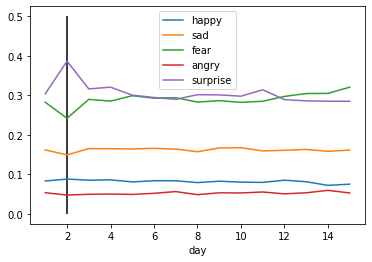

In [164]:
ax=emo.plot(kind="line", x="day", y="happy")
emo.plot(kind="line", x="day", y="sad", ax=ax)
emo.plot(kind="line", x="day", y="fear", ax=ax)
emo.plot(kind="line", x="day", y="angry", ax=ax)
emo.plot(kind="line", x="day", y="surprise", ax=ax)
ax.vlines(2,0,0.5,color='k')